# Molecule Detection by Matched Filtering and Adaptive Probabilistic Thresholding in Simulated Signal with Poisson-Gaussian Noise
MH, v1.1, 2024_10_11

## Common
This section contains code for importing standard libraries, supporting functions and initialization. 

### Libraries

In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd

In [2]:
from numpy import mean, var, round, min, max, sum, median, std, sqrt

### Import Functions

In [3]:
from show import show_image
from show import show_histogram

In [28]:
from signal_generation import get_uniform_background_poisson_awgn
from signal_generation import get_nonuniform_background_poisson_awgn
from signal_generation import gauss2d
from signal_generation import get_multi_spot_uniform_background_poisson_awgn
from signal_generation import get_multi_spot_nonuniform_background_poisson_awgn
from signal_generation import get_mf

from detection_tools import get_detection_points
from detection_tools import get_square_annulus
from detection_tools import get_disk_annulus

from poisson_pmf import test_statistic
from gauss_nofilter import cacfar

### Initialization

In [5]:
# setting parameters for visualization
mpl.rc('image', cmap='plasma')
mpl.rcParams['figure.figsize'] = (6,4)
mpl.rcParams['font.size'] = 12

In [6]:
# random number generator starting value
seed = 0

## Simulation
This section shows an example of our detection algorithm over synthetically generated data.
The following subsections contain parameters for signal generation, matched filtering, and detection.

### Parameters

#### Signal Generation Parameters

In [7]:
# image size
size = 128
shape = (size,size)

In [8]:
# uniform background
b = 1000 # mean level

In [9]:
# non-uniform background
background_parabola_curve = 10
(background_parabola_x0, background_parabola_y0) = (0,0)

In [10]:
# read-out additive white gaussian noise 
sigma_n = 20

In [11]:
# standard deviation of point spread function in pixels
sigma = 1

In [12]:
# multiple molecules
n_spots = 30

# mean and stadard deviation of psf width of the generated molecules
multispot_sigma_mean = 1
multispot_sigma_std = 0.1

# mean and standard deviation of photon count of the generated molecules
multispot_a_mean = 1500
multispot_a_std = 100

# margin where molecules are not present
multispot_margin = int(np.ceil(3*sigma))

In [13]:
# The background and signal generation parameters are stored in the following dicitonaries.
background_dict = {
    'mean': b, 
    'center': (background_parabola_x0, background_parabola_y0),
    'curve': background_parabola_curve,
    'sigma_n': sigma_n,        
    'size': size,
    'shape': (size,size),
}

signal_dict = {
    'sigma': sigma,
    'n_spots': n_spots,    
    'multispot_sigma_mean': multispot_sigma_mean,
    'multispot_sigma_std': multispot_sigma_std,
    'multispot_a_mean': multispot_a_mean,
    'multispot_a_std': multispot_a_std,    
    'multispot_margin': multispot_margin,
    'size': size,
}

#### Matched Filter (MF) Parameters

In [14]:
# standard deviation of matched filter in pixels
mf_sigma = sigma

In [15]:
# one-sided range of matched filter kernel in pixels
mf_range = int(np.ceil(3*sigma))

#### Detection Parameters

In [16]:
# probability of false positive (i.e., probability of false alarm)
pfa = 10**-4

In [17]:
# guard and reference interval in pixels of doughnut-shape kernel
# for local background estimation
guard_interval = int(np.ceil(3*sigma))
reference_interval = int(np.ceil(3*sigma))

In [18]:
# size of local maxima search in pixels
local_max_range = int(np.ceil(3*sigma))

### Signal Generation
In this section the tested signal is generated. It is a signal with multiple molecules on non-uniform parabolic background in Poisson and Gaussian noise.

#### PSF

In [19]:
# here the psf is set to be 2d Gaussian; integrated Gaussian is also available 
# in the supporting Python functions
psf_fun = gauss2d

#### Multiple Spots

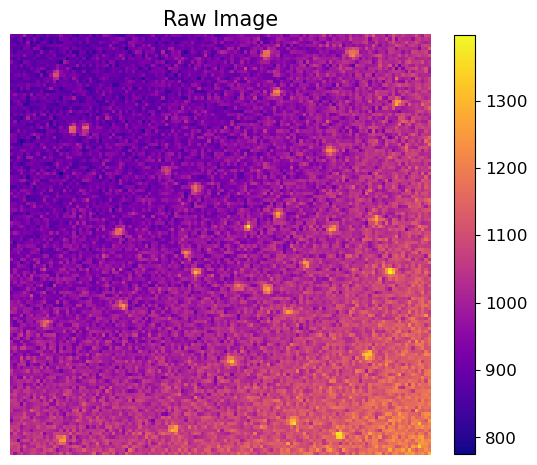

In [20]:
# here noisy multi molecule signal on non-uniform background is generated
multi_spot_nonuniform_background_poisson_awgn = get_multi_spot_nonuniform_background_poisson_awgn(
    signal_dict, psf_fun, background_dict, seed=seed)

show_image(multi_spot_nonuniform_background_poisson_awgn, title='Raw Image')

### Detection
This section demonstrates the use of the detector on a synthetically generated signal. The signal is marked with the symbol "r", as "received". It is filtered by the matched filter with kernel "w". We denote the filter output as the test statistic "T". The output of the adaptive thresholding is then a list of coordinates of the detected molecules labeled as "points". The user sets the false positive detection rate using the parameter "pfa", which is the probability of false positives.

#### Received Signal

In [21]:
r1_nonuniform = multi_spot_nonuniform_background_poisson_awgn

#### Filtering

In [22]:
# matched filter kernel
w = get_mf(psf_fun, mf_sigma, mf_range)

In [23]:
# filtered signal is test statistic
T1_nonuniform = test_statistic(r1_nonuniform, w)

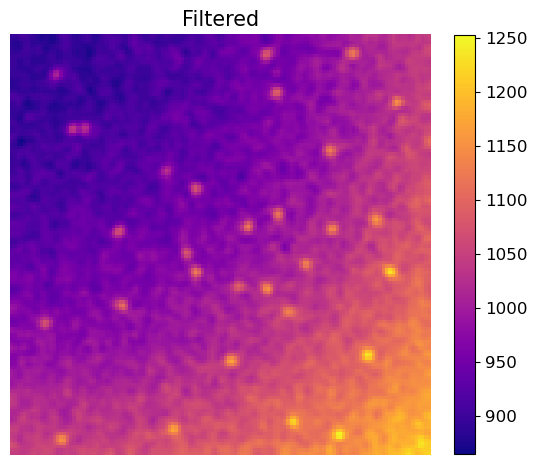

In [24]:
show_image(T1_nonuniform, title='Filtered')

#### Adaptive Thresholding

In [25]:
# kernel for adaptive background estimation
square_annulus = get_square_annulus(guard_interval, reference_interval)

In [26]:
# list of detection coordinates
T1_nonuniform_points = get_detection_points(
    T1_nonuniform, cacfar, pfa, local_max_range, kernel=square_annulus)

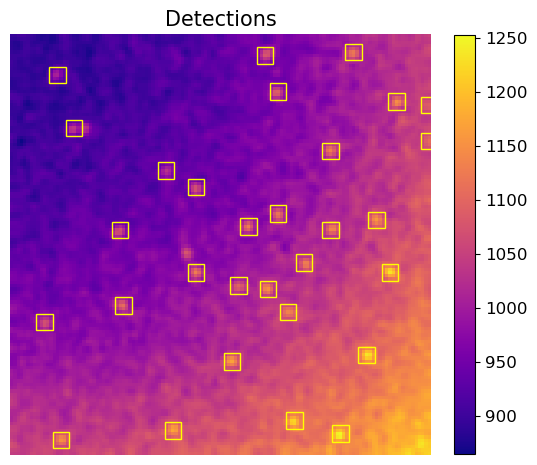

In [27]:
# shown detections
show_image( T1_nonuniform, points=T1_nonuniform_points, title='Detections' )